Text(0.5, 1.0, 'Label 8')

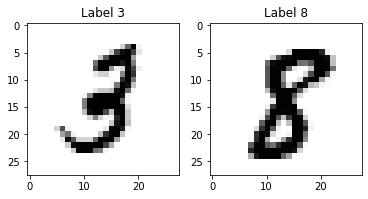

In [1]:
#https://danielmuellerkomorowska.com/2021/01/05/introduction-to-t-sne-in-python-with-scikit-learn/
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt
 
# Load the MNIST data
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
 
# Randomly select 1000 samples for performance reasons
np.random.seed(100)
subsample_idc = np.random.choice(X.shape[0], 1000, replace=False)
X = X[subsample_idc,:]
y = y[subsample_idc]
 
# Show two example images
fig, ax = plt.subplots(1,2)
ax[0].imshow(X[11,:].reshape(28,28), 'Greys')
ax[1].imshow(X[15,:].reshape(28,28), 'Greys')
ax[0].set_title("Label 3")
ax[1].set_title("Label 8")

In [2]:
X.shape
# (1000, 784)
# 1000 Samples with 784 features
y.shape
# (1000,)
# 1000 labels
np.unique(y)
# array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)
# The 10 classes of the images

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

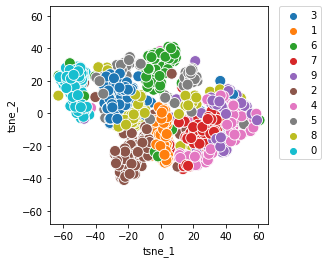

In [3]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
 
# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(X)
tsne_result.shape
# (1000, 2)
# Two dimensions for each of our images
 
# Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

Text(0.5, 1.0, 'Sorted by Label')

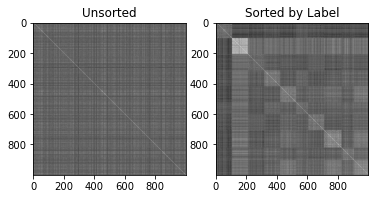

In [4]:
from sklearn.metrics import pairwise_distances
y_sorted_idc = y.argsort()
X_sorted = X[y_sorted_idc]
 
distance_matrix = pairwise_distances(X,
                                     metric='euclidean')
 
distance_matrix_sorted = pairwise_distances(X_sorted,
                                            metric='euclidean')
 
fig, ax = plt.subplots(1,2)
ax[0].imshow(distance_matrix, 'Greys')
ax[1].imshow(distance_matrix_sorted, 'Greys')
ax[0].set_title("Unsorted")
ax[1].set_title("Sorted by Label")

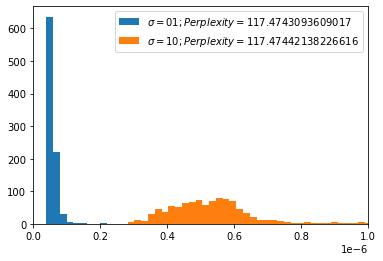

In [5]:
from scipy.stats import t, entropy
 
x = distance_matrix[0,1:]
t_dist_sigma01 = t(df=1.0, loc=0.0, scale=1.0)
t_dist_sigma10 = t(df=1.0, loc=0.0, scale=10.0)
P_01 = t_dist_sigma01.pdf(x)
P_10 = t_dist_sigma10.pdf(x)
 
perplexity_01 = 2**entropy(P_01)
perplexity_10 = 2**entropy(P_10)
 
dist_min = min(P_01.min(), P_10.min())
dist_max = max(P_01.max(), P_10.max())
bin_size = (dist_max - dist_min) / 100
bins = np.arange(dist_min+bin_size/2, dist_max+bin_size/2, bin_size)
fig, ax = plt.subplots(1)
ax.hist(P_01, bins=bins)
ax.hist(P_10, bins=bins)
ax.set_xlim((0, 1e-6))
ax.legend((r'$\sigma = 01; Perplexity = $' + str(perplexity_01),
           r'$\sigma = 10; Perplexity = $' + str(perplexity_10)))


In [6]:
from sklearn.manifold import _t_sne
 
perplexity = 30  # Same as the default perplexity
p = _t_sne._joint_probabilities(distances=distance_matrix,
                        desired_perplexity = perplexity,
                        verbose=False)

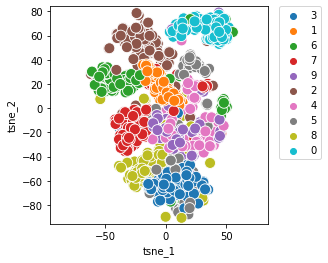

In [7]:
# Create the initial embedding
n_samples = X.shape[0]
n_components = 2
X_embedded = 1e-4 * np.random.randn(n_samples,
                                    n_components).astype(np.float32)
 
embedding_init = X_embedded.ravel()  # Flatten the two dimensional array to 1D
 
# kl_kwargs defines the arguments that are passed down to _kl_divergence
kl_kwargs = {'P': p,
             'degrees_of_freedom': 1,
             'n_samples': 1000,
             'n_components':2}
 
# Perform gradient descent
embedding_done = _t_sne._gradient_descent(_t_sne._kl_divergence,
                                          embedding_init,
                                          0,
                                          1000,
                                          kwargs=kl_kwargs)
 
# Get first and second TSNE components into a 2D array
tsne_result = embedding_done[0].reshape(1000,2)
 
# Convert do DataFrame and plot
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0],
                               'tsne_2': tsne_result[:,1],
                               'label': y})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
